In [22]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
census_blocks_df = pd.read_csv('../block_shapes/CensusBlockTIGER2010.csv')
census_blocks_df[census_blocks_df['TRACT_BLOC']==6903002010]

block_dict = {}
for index, row in census_blocks_df.iterrows():
    block_coord = row['the_geom'].split(" ")
    lat_pat = re.compile('[^-\d][\d]+[.][\d]+')
    lats = lat_pat.findall(str(block_coord))
    long_pat = re.compile('[-][\d]+[.][\d]+')
    longs = long_pat.findall(str(block_coord))
    float_lats = [float(x[1:]) for x in lats]
    avg_lat = sum(float_lats)/len(float_lats)
    float_longs = [float(x) for x in longs]
    avg_long = sum(float_longs)/len(float_longs)

    block_dict[row['TRACT_BLOC']] = [avg_lat, avg_long]

In [3]:
import math
from collections import defaultdict

In [4]:
with open('../yelp/yelp_coffee_shop_dict.pk', 'rb') as read_file:
    coffee_shops = pickle.load(read_file)

In [9]:
dist = 41.645288-41.654156
dist

-0.008867999999999654

In [13]:
block_coffee_dict = defaultdict(int)
for key_b, value_b in block_dict.items():
    count = 0
    for key_c, value_c in coffee_shops.items():
        lat_block = value_b[0]
        lon_block = value_b[1]
        lat_shop = value_c[2]
        lon_shop = value_c[3]
        dist = abs(lat_block - lat_shop) + abs(lon_block - lon_shop)
        if dist < .001:
            block_coffee_dict[key_b] += 1
            count+=1
        else:
            block_coffee_dict[key_b] += 0


In [15]:
# with open('man_dist_coffee_small.p','wb') as write_file:
#     pickle.dump(block_coffee_dict, write_file)

In [63]:
coffee_count_list = [value for key,value in block_coffee_dict.items()]
# plt.hist(coffee_count_list, bins=20, range=[0,3])
oneormore_coffee_list = [value for shop,value in block_coffee_dict.items() if value>=1 ]

In [7]:
df_businesses = pd.read_csv('../Business_Licenses_-_Current_Active.csv')
business_dict = {}
for i,row in df_businesses.iterrows():
    business_dict[row['LICENSE ID']] = [row.LATITUDE, row.LONGITUDE]

In [38]:
block_bus_dict = defaultdict(int)
count = 0
count_mod = count % 100
for key_b, value_b in block_dict.items():
    for key_bus, value_bus in business_dict.items():
        lat_block = value_b[0]
        lon_block = value_b[1]
        lat_bus = value_bus[0]
        lon_bus = value_bus[1]
        dist = abs(lat_block -lat_bus) + abs(lon_block - lon_bus)
        if dist < .001:
            block_bus_dict[key_b] += 1
        else:
            block_bus_dict[key_b] += 0
    count+=1
    if count%1000 == 0:
        print(count)
    if count%2000 == 0:
        print(count, count)

1000
2000
2000 2000
3000
4000
4000 4000
5000
6000
6000 6000
7000
8000
8000 8000
9000
10000
10000 10000
11000
12000
12000 12000
13000
14000
14000 14000
15000
16000
16000 16000
17000
18000
18000 18000
19000
20000
20000 20000
21000
22000
22000 22000
23000
24000
24000 24000
25000
26000
26000 26000
27000
28000
28000 28000
29000
30000
30000 30000
31000
32000
32000 32000
33000
34000
34000 34000
35000
36000
36000 36000
37000
38000
38000 38000
39000
40000
40000 40000
41000
42000
42000 42000
43000
44000
44000 44000
45000
46000
46000 46000


In [52]:
# with open('man_dist_bus_small.p','wb') as write_file:
#     pickle.dump(block_bus_dict, write_file)

(array([26814.,  7293.,  2755.,  1743.,  1177.,   999.,   785.,   650.,
          555.,   851.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

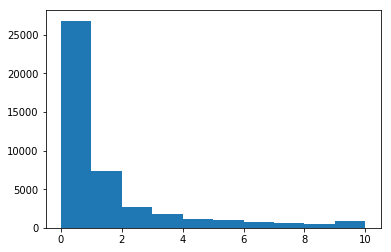

In [53]:
business_count_list = [value for key,value in block_bus_dict.items()]
plt.hist(business_count_list, bins=10, range=[0,10])

## Closest EL

In [73]:
with open('../cta/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv', 'rb') as read_file:
    cta_data = pd.read_csv(read_file)

In [74]:
total_rides = cta_data.groupby(['station_id','stationname']).sum()
station_rows = cta_data.groupby(['station_id','stationname']).count()
cta_rides_and_counts = pd.merge(total_rides, station_rows, left_index = True, right_index=True)
cta_rides_and_counts.drop(columns = ['date', 'daytype'], inplace=True)
cta_rides_and_counts
cta_rides_and_counts.rename(index=str, columns = {'rides_x':'total_rides', 'rides_y':'days_counted'}, inplace=True)
cta_rides_and_counts['avg_rides_per_day'] = cta_rides_and_counts['total_rides']/cta_rides_and_counts['days_counted']

In [75]:
df_el_nodups = df_el_stops.drop_duplicates(subset='STATION_NAME')
df_el = pd.merge(cta_rides_and_counts, df_el_nodups, left_on='stationname' ,right_on='STATION_NAME')
df_el_smaller = df_el[['STATION_NAME', 'STOP_ID', 'avg_rides_per_day', 'Location']]

conv_lat_long = []
for index,value in df_el_smaller.iterrows():
    df_lat_long = value['Location']

    lat_long = df_lat_long.split(" ")

    lat_pat = re.compile('[^-][\w][\d]+[.][\d]+')
    lat = lat_pat.match(str(lat_long[0]))
    long_pat = re.compile('[-][\d]+[.][\d]+')
    long = long_pat.findall(str(lat_long[1]))
    conv_lat_long.append([float(lat[0][1:]), float(long[0])])

df_el_smaller['lat_long'] = conv_lat_long

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
closest_avg_rides_dict = defaultdict(list)
for key, value in block_dict.items():
    closest_stop_coord = 100
    closest_stop = ''
    closest_avg_rides = 0
    for index, row in df_el_smaller.iterrows():
        lat_dist = abs(value[0] - row['lat_long'][0])
        long_dist = abs(value[1] - row['lat_long'][1])
        distance= lat_dist+long_dist
        if distance < closest_stop_coord:
            closest_stop_coord = distance
            closest_stop = row['STATION_NAME']
            closest_avg_rides = row['avg_rides_per_day']
    closest_avg_rides_dict[key] =[closest_stop, closest_stop_coord, closest_avg_rides]

## best shops

In [79]:
with open('../../notebooks/best_coffee_block_dict.p','rb') as read_file:
    best_cf = pickle.load(read_file)

In [111]:
df_best_shops = pd.DataFrame.from_dict(best_cf, orient='index')

In [112]:
df_best_shops.head()

,0
6903002010,0
6809003007,0
6809003013,0
2909004019,0
2925004016,0


## census_pops

In [87]:
df_pop = pd.read_csv('../population_censusblock/Population_by_2010_Census_Block.csv')

## Merge dicts

In [137]:
df_coffee_count = pd.DataFrame.from_dict(block_coffee_dict, orient='index')
df_business_count = pd.DataFrame.from_dict(block_bus_dict, orient='index')
df = pd.merge(df_business_count, df_coffee_count, left_index=True, right_index=True)
df.rename(columns = {'0_x':'business_per_sqmi', '0_y':'coffee_per_sqmi'}, inplace=True)
df_closest_el = pd.DataFrame.from_dict(closest_avg_rides_dict, orient='index')
df = pd.merge(df, df_closest_el, left_index=True, right_index=True)
df = pd.merge(df_pop,df,left_on='CENSUS BLOCK',right_index=True)
df.drop(columns = ['CENSUS BLOCK FULL'], inplace=True)
df = pd.merge(df, df_best_shops, left_on='CENSUS BLOCK', right_index=True)
block_dict_df = pd.DataFrame.from_dict(block_dict, orient='index' )
df = pd.merge(df, block_dict_df, left_on='CENSUS BLOCK', right_index=True)
df.head()


,CENSUS BLOCK,TOTAL POPULATION,business_per_sqmi,coffee_per_sqmi,0_x,1_x,2,0_y,0,1_y
0,101001000,128,2,0,Jarvis,0.009465,1347.408038,0,42.022564,-87.666316
1,101001001,71,0,0,Jarvis,0.007069,1347.408038,0,42.022424,-87.668571
2,101001002,45,0,0,Jarvis,0.006355,1347.408038,0,42.022033,-87.668894
3,101001003,335,0,0,Jarvis,0.005944,1347.408038,0,42.021412,-87.668684
4,101002000,152,0,0,Howard,0.005396,5357.830394,0,42.022552,-87.670984


In [138]:
df.rename(columns={'business_per_sqmi':'bus_within_001', 'coffee_per_sqmi':'cof_within_001',
                   '0_x':'closest_el', '1_x':'dist_to_closest_el', 
                   2:'daily_rides_closest_el', '0_y':'best_shops_under_001',
                   0:'block_lat', '1_y':'block_lon'})


,CENSUS BLOCK,TOTAL POPULATION,bus_within_001,cof_within_001,closest_el,dist_to_closest_el,daily_rides_closest_el,best_shops_under_001,block_lat,block_lon
0,101001000,128,2,0,Jarvis,0.009465,1347.408038,0,42.022564,-87.666316
1,101001001,71,0,0,Jarvis,0.007069,1347.408038,0,42.022424,-87.668571
2,101001002,45,0,0,Jarvis,0.006355,1347.408038,0,42.022033,-87.668894
3,101001003,335,0,0,Jarvis,0.005944,1347.408038,0,42.021412,-87.668684
4,101002000,152,0,0,Howard,0.005396,5357.830394,0,42.022552,-87.670984
5,101002001,45,0,0,Howard,0.004499,5357.830394,0,42.022769,-87.672099
6,101002002,363,0,0,Howard,0.005295,5357.830394,0,42.022684,-87.674566
7,101002003,42,0,0,Howard,0.005318,5357.830394,0,42.021859,-87.670370
8,101002004,154,0,0,Howard,0.005039,5357.830394,0,42.022041,-87.670831
9,101002005,151,0,0,Howard,0.003885,5357.830394,0,42.021708,-87.671652


In [120]:
df.rename(columns={'business_per_sqmi':'bus_within_001', 'coffee_per_sqmi':'cof_within_001',
                   '0_x':'closest_el', 1:'dist_to_closest_el', 
                   2:'daily_rides_closest_el', '0_y':'best_shops_under_001'})

,CENSUS BLOCK,CENSUS BLOCK FULL,TOTAL POPULATION,bus_within_001,cof_within_001,closest_el,dist_to_closest_el,daily_rides_closest_el,best_shops_under_001
0,101001000,170310101001000,128,2,0,Jarvis,0.009465,1347.408038,0
1,101001001,170310101001001,71,0,0,Jarvis,0.007069,1347.408038,0
2,101001002,170310101001002,45,0,0,Jarvis,0.006355,1347.408038,0
3,101001003,170310101001003,335,0,0,Jarvis,0.005944,1347.408038,0
4,101002000,170310101002000,152,0,0,Howard,0.005396,5357.830394,0
5,101002001,170310101002001,45,0,0,Howard,0.004499,5357.830394,0
6,101002002,170310101002002,363,0,0,Howard,0.005295,5357.830394,0
7,101002003,170310101002003,42,0,0,Howard,0.005318,5357.830394,0
8,101002004,170310101002004,154,0,0,Howard,0.005039,5357.830394,0
9,101002005,170310101002005,151,0,0,Howard,0.003885,5357.830394,0


In [139]:
with open('../../models/dataframes/df_under001.p','wb') as write_file:
    pickle.dump(df, write_file)